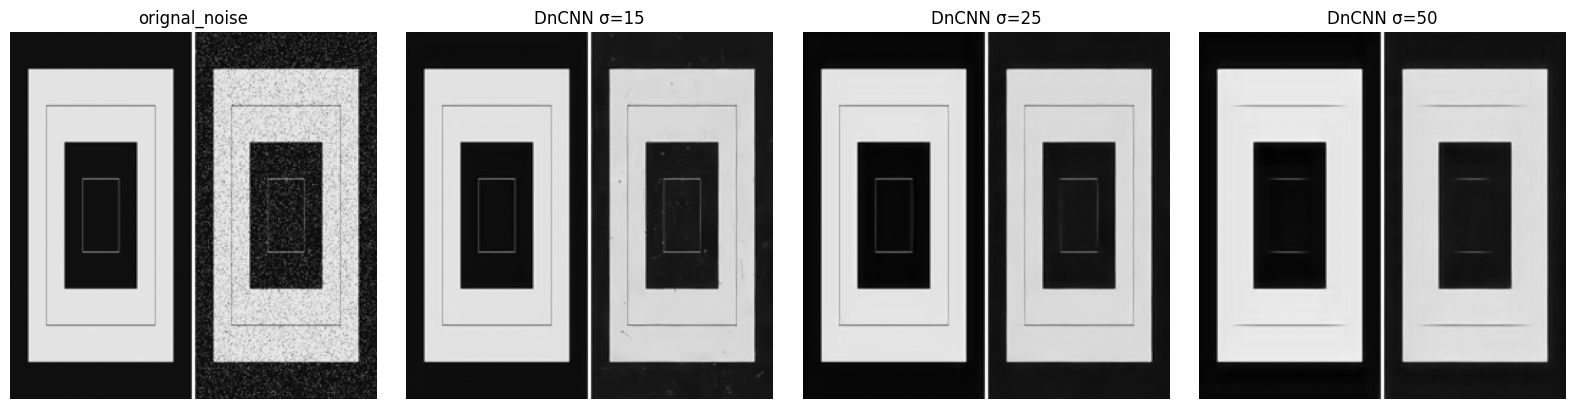

In [ ]:
# 安裝套件
#!pip install -q torch torchvision matplotlib scikit-image

# 匯入必要套件
import torch
import torch.nn as nn
import torchvision.transforms as T
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from skimage import img_as_float32

#DnCNN 架構（bias=False）
class DnCNN(nn.Module):
    def __init__(self, channels=1, num_of_layers=17):
        super(DnCNN, self).__init__()
        layers = [nn.Conv2d(channels, 64, 3, padding=1, bias=False), nn.ReLU(inplace=True)]
        for _ in range(num_of_layers - 2):
            layers += [
                nn.Conv2d(64, 64, 3, padding=1, bias=False),
                nn.BatchNorm2d(64),
                nn.ReLU(inplace=True)
            ]
        layers.append(nn.Conv2d(64, channels, 3, padding=1, bias=False))
        self.dncnn = nn.Sequential(*layers)

    def forward(self, x):
        return x - self.dncnn(x)

#載入三個模型
def load_model(path):
    model = DnCNN()
    state_dict = torch.load(path, map_location='cpu')
    state_dict = {k.replace('module.', ''): v for k, v in state_dict.items()}
    model.load_state_dict(state_dict)
    model.eval()
    return model

model15 = load_model('/content/sigma15.pth')
model25 = load_model('/content/sigma25.pth')
model50 = load_model('/content/sigma50.pth')

#載入一張有雜訊的圖片
image = Image.open('/content/noise.jpg').convert('L').resize((256, 256))
noisy = img_as_float32(np.array(image)).astype(np.float32)

#預處理
transform = T.ToTensor()
noisy_tensor = transform(noisy).unsqueeze(0)

#使用三個模型推論
with torch.no_grad():
    den15 = model15(noisy_tensor).squeeze().numpy()
    den25 = model25(noisy_tensor).squeeze().numpy()
    den50 = model50(noisy_tensor).squeeze().numpy()

#顯示對照圖
fig,axs = plt.subplots(1, 4, figsize=(16, 4))
axs[0].imshow(noisy, cmap='gray'); axs[0].set_title("orignal_noise")
axs[1].imshow(den15, cmap='gray'); axs[1].set_title("DnCNN σ=15")
axs[2].imshow(den25, cmap='gray'); axs[2].set_title("DnCNN σ=25")
axs[3].imshow(den50, cmap='gray'); axs[3].set_title("DnCNN σ=50")
for ax in axs: ax.axis('off')
plt.tight_layout()
plt.show()
